In [89]:
data_dir = "/kaggle/input/cse475-project"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

### Import Libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

### Load Dataset

In [91]:
df.head()

,file_path,label
0,/kaggle/input/cse475-project/train/Malignant,train
1,/kaggle/input/cse475-project/train/Benign,train
2,/kaggle/input/cse475-project/test/Benign,test
3,/kaggle/input/cse475-project/test/Malignant,test


In [92]:
df.tail()

,file_path,label
0,/kaggle/input/cse475-project/train/Malignant,train
1,/kaggle/input/cse475-project/train/Benign,train
2,/kaggle/input/cse475-project/test/Benign,test
3,/kaggle/input/cse475-project/test/Malignant,test


In [93]:
df.shape

(4, 2)

In [94]:
class_counts = df['label'].value_counts()
print(class_counts)

label
train    2
test     2
Name: count, dtype: int64


In [95]:
df.describe()

,file_path,label
count,4,4
unique,4,2
top,/kaggle/input/cse475-project/train/Malignant,train
freq,1,2


In [96]:
print("Null values in each column:")
print(df.isnull().sum())

Null values in each column:
file_path    0
label        0
dtype: int64


In [97]:
df_cleaned = df.dropna()
print("Null values after cleaning:")
print(df_cleaned.isnull().sum())

Null values after cleaning:
file_path    0
label        0
dtype: int64


### Split the Dataset into Features and Labels


*   **Features:** (Independent variables) These are the input characteristics or attributes of the data points.
*   **Labels:** (Dependent Variables) These are the outcomes or target variables that we want to predict.



In [98]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [99]:
print(X.shape)
print(y.shape)

(4, 1)
(4,)


### Split the Dataset into Training and Testing Sets

*   **Training Set:** Used to teach the model the underlying patterns and relationships within the data.
*   **Test Set:** Evaluates the model's performance on data it hasn't seen before.



In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
print(len(X_train))
print(len(X_test))

3
1


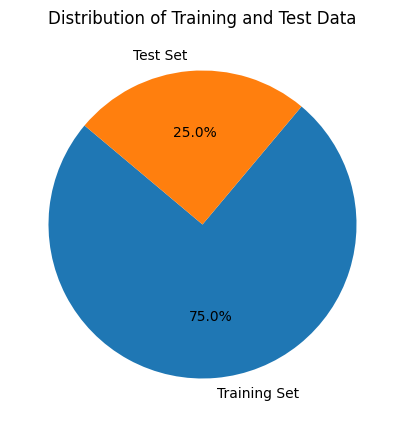

In [102]:
sizes = [len(X_train), len(X_test)]
labels = ['Training Set', 'Test Set']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Training and Test Data')
plt.show()

### ANN Model Design and Implementation

In [108]:
print("Type of X_train:", type(X_train))
print("First element type:", type(X_train[0]))

Type of X_train: <class 'numpy.ndarray'>
First element type: <class 'numpy.ndarray'>


In [118]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import os
from glob import glob

# 1. Get all image files from directories
def get_image_paths(directory):
    """Get all image files from a directory"""
    return sorted(glob(os.path.join(directory, '*.jpg')) + 
                 glob(os.path.join(directory, '*.jpeg')) + 
                 glob(os.path.join(directory, '*.png')))

# 2. Rebuild your dataset with actual image files
train_malignant = get_image_paths('/kaggle/input/cse475-project/train/Malignant')
train_benign = get_image_paths('/kaggle/input/cse475-project/train/Benign')
test_malignant = get_image_paths('/kaggle/input/cse475-project/test/Malignant')
test_benign = get_image_paths('/kaggle/input/cse475-project/test/Benign')

# 3. Create proper X and y arrays
X_train = np.array(train_malignant + train_benign)
X_test = np.array(test_malignant + test_benign)
y_train = np.array([1]*len(train_malignant) + [0]*len(train_benign))  # 1=Malignant, 0=Benign
y_test = np.array([1]*len(test_malignant) + [0]*len(test_benign))    # Fixed missing parenthesis

# 4. Image preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 5. Improved image loading
def load_images(paths):
    images = []
    for path in paths:
        try:
            img = Image.open(path).convert('RGB')
            images.append(transform(img))
        except Exception as e:
            print(f"Skipping corrupt file {path}: {str(e)}")
    return torch.stack(images) if images else torch.zeros(0, 3, 128, 128)

# 6. Convert to tensors
X_train_tensor = load_images(X_train)
X_test_tensor = load_images(X_test)
y_train_tensor = torch.from_numpy(y_train.astype(np.int64))
y_test_tensor = torch.from_numpy(y_test.astype(np.int64))

# 7. Verification
print("\nDataset successfully created!")
print(f"Training set: {len(X_train)} images ({len(train_malignant)} malignant, {len(train_benign)} benign)")
print(f"Test set: {len(X_test)} images ({len(test_malignant)} malignant, {len(test_benign)} benign)")
print(f"X_train tensor shape: {X_train_tensor.shape}")
print(f"y_train tensor shape: {y_train_tensor.shape}")


Dataset successfully created!
Training set: 11879 images (5590 malignant, 6289 benign)
Test set: 2000 images (1000 malignant, 1000 benign)
X_train tensor shape: torch.Size([11879, 3, 128, 128])
y_train tensor shape: torch.Size([11879])


In [122]:
class ANN_model(nn.Module):
    # For ANN we will require input layer, hidden layer and output layer
    def __init__(self, input_features=8, hidden1=20, hidden2=20, out_features=2):
        # Inherit parent class i.e.nn.Module
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1, hidden2)
        self.out=nn.Linear(hidden2,out_features)
    # x will track the gradient descent and all the propogation
    def forward(self,x):
        # F we have all the activation functions
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=self.out(x)
        return x

In [123]:
model = ANN_model()

In [124]:
print(model.parameters)

<bound method Module.parameters of ANN_model(
  (f_connected1): Linear(in_features=8, out_features=20, bias=True)
  (f_connected2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)>


### Model Training

In [125]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [129]:
import torch.nn as nn

# 1. Correct Model Architecture
class ANN_model(nn.Module):
    def __init__(self, input_features=49152, hidden1=256, hidden2=128, out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features, hidden1)
        self.f_connected2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, out_features)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # [batch_size, 49152]
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x

# 2. Initialize Model with Correct Input Size
model = ANN_model(input_features=3*128*128)  # 3 channels * 128 height * 128 width

# 3. Training Function with Batch Processing
def train_model(model, train_loader, epochs=10):
    model.train()
    loss_values = []
    
    for epoch in tqdm(range(epochs), desc='Training Epochs'):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        loss_values.append(epoch_loss/len(train_loader))
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_values[-1]:.4f}')
    
    return loss_values

# 4. Create DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 5. Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

loss_values = train_model(model, train_loader, epochs=500)

Training Epochs:  20%|██        | 100/500 [03:17<12:59,  1.95s/it]

Epoch [100/500], Loss: 0.1206


Training Epochs:  40%|████      | 200/500 [06:35<09:53,  1.98s/it]

Epoch [200/500], Loss: 0.0766


Training Epochs:  60%|██████    | 300/500 [09:53<06:31,  1.96s/it]

Epoch [300/500], Loss: 0.0301


Training Epochs:  80%|████████  | 400/500 [13:11<03:18,  1.99s/it]

Epoch [400/500], Loss: 0.0638


Training Epochs: 100%|██████████| 500/500 [16:31<00:00,  1.98s/it]

Epoch [500/500], Loss: 0.0303


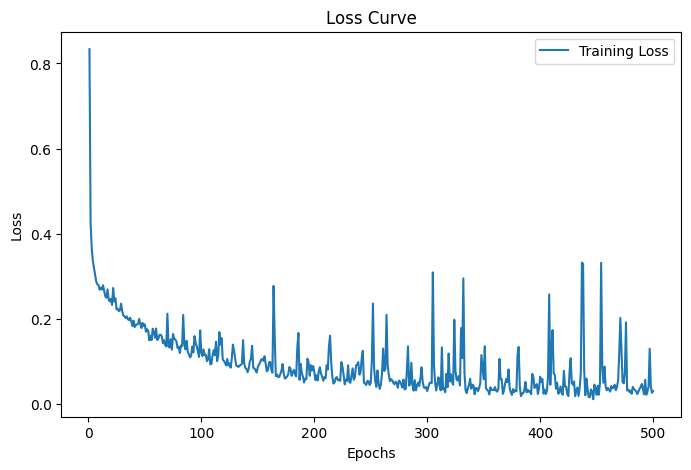

In [130]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### Model Evaluation

In [132]:
def evaluate_model_with_class_accuracy(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Overall Accuracy: {accuracy:.4f}')
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Per-class accuracy
    for i, class_name in enumerate(class_names):
        class_mask = [True if label == i else False for label in all_labels]
        class_acc = accuracy_score(np.array(all_labels)[class_mask], 
                                 np.array(all_preds)[class_mask])
        print(f'Accuracy for {class_name}: {class_acc:.4f}')

# Create test DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
class_names = ['Benign', 'Malignant']  # Update with your actual class names
evaluate_model_with_class_accuracy(model, test_loader, class_names)

Overall Accuracy: 0.9270

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.93      0.93      1000
   Malignant       0.93      0.93      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

Accuracy for Benign: 0.9250
Accuracy for Malignant: 0.9290


### Confusion Matrix

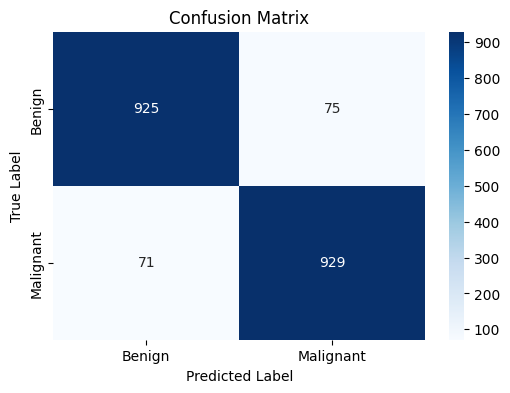

In [134]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Create test DataLoader (if not already created)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, ['Benign', 'Malignant'])